# Building a Recommender System Using MovieLens

![Movie Lens](movielens.png)

---

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import time
import random

import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.6, rc={"lines.linewidth": 2})
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.model_selection.split import KFold
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SVDpp, NMF

np.random.seed(42)

### Dataset

In [2]:
df = pd.read_csv('MovieLens-Ratings.csv', na_values=-1)

---

## Part I: Exploratory Data Analysis

### Description of Dataset

The dataset used in this project originates from the [MovieLens](https://grouplens.org/datasets/movielens/)
dataset, a research initiative conducted by GroupLens Research, situated in the Department of Computer Science and Engineering at the University of Minnesota. This dataset contains a collection of movie ratings, comprising 27,753,444 ratings, spanning 58,098 different movies and involving 283,228 users. Data collection for this dataset extended from January 09, 1995, to September 26, 2018, with the dataset being compiled on September 26, 2018.

The users included in this dataset were chosen at random for inclusion. Furthermore, all selected users had rated at least one movie. It's important to note that the dataset provides user identification (user ID) for each user, but no additional demographic information was collected during data acquisition.

The file structure of the MovieLens dataset is such that each line corresponds to a single movie rating provided by a particular user and adheres to the following format: `userId`, `movieId`, `rating`, `timestamp`. The lines within the file are organized first by `userId` and then, within each user, by `movieId`. The ratings within this dataset are expressed on a five-star scale, allowing for half-star increments, ranging from 0.5 stars to 5.0 stars. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [4]:
df.head(n=-20)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753419,283228,3578,5.0,1379882818
27753420,283228,3897,4.5,1379882900
27753421,283228,4310,3.0,1354118775
27753422,283228,4886,5.0,1379882828


In [5]:
df.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


The dataset is clean, with no missing values (NA's) or duplicated entries, so there is no need for additional data cleaning techniques at this point. Furthermore, the dataset includes records from a total of 283,228 unique users. There is a diverse collection of 53,889 unique movies in the dataset.

In [6]:
df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
unique_users = len(df['userId'].unique())
unique_movie = len(df['movieId'].unique())

print('missing values: ' + str(round(percent_missing['rating'], 2)) + '%')
print('unique users: ' + str(unique_users))
print('unique movies: ' + str(unique_movie))

missing values: 0.0%
unique users: 283228
unique movies: 53889


### Distribution of Movie Ratings

This figure illustrates the distribution of movie ratings within the MovieLens dataset. The horizontal axis resperents the range of ratings given to movies. The vertical axis represents the count of movies that received a rating falling within each of the specific range (or bin). The plot indicates that the majority of ratings fall within the 3-star and 4-star range. The distribution of the ratings is slightly skewed to the left.

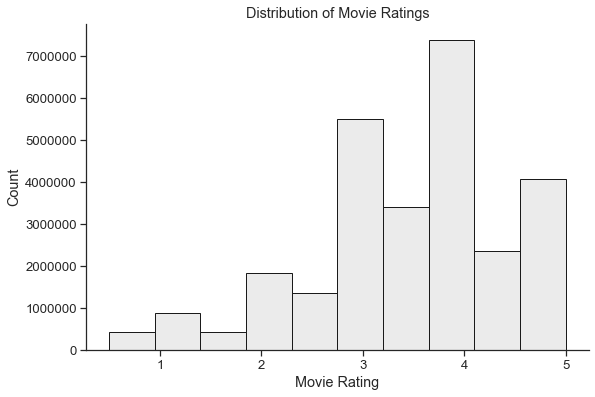

In [9]:
# set style for sns plots
plt.figure(figsize=[9,6])
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.2)

# create distribution plot for movie ratings
ax = sns.histplot(data=df, x="rating", bins=10, edgecolor='k', color="#E5E5E5")
ax.set(title="Distribution of Movie Ratings", ylabel="Count", xlabel="Movie Rating")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):}'))
plt.show()

In [10]:
# Count the number of ratings for each unique rating value
rating_counts = df['rating'].value_counts().sort_index()
rating_table = pd.DataFrame({'Rating': rating_counts.index, 'Count': rating_counts.values})
rating_table

,Rating,Count
0,0.5,442388
1,1.0,886233
2,1.5,441354
3,2.0,1850627
4,2.5,1373419
5,3.0,5515668
6,3.5,3404360
7,4.0,7394710
8,4.5,2373550
9,5.0,4071135


### Density of Movie IDs

**Distribution of the Number of Movie Ratings**   
The plot of the left below displays the distribution of movie ratings in the MovieLens dataset. On the horizontal axis, you can see the number of ratings given to movies, divided into various bins. The vertical axis represents the count of movies that fall into each of these rating count bins. Each bar in the histogram indicates how many movies received a specific number of ratings.    

This specific plot shows how many movies received a certain number of ratings, helping us understand the distribution of movie popularity based on the number of user ratings they have received. The plot shows that there is a range of movies with varying numbers of ratings, with very few being more popular. Most movies contain a very low number of ratings.

**Density Plot of Movie IDs**   
Since each row in the dataset represents one rating, the plot on the right effectively shows the distribution of movies within the dataset based on how frequently they appear in the ratings data. The horizontal axis represents movie IDs, and each movie ID is plotted according to its frequency in the dataset. The vertical axis represents the density of movie IDs, indicating how concentrated or sparse the movie IDs are within the dataset. The plot provides insights into which movies are more frequently rated or appear more often in the dataset compared to others. Once more, this plot underscores the fact that only a small number of movies receive frequent ratings, while the majority of movies are rated far less frequently.

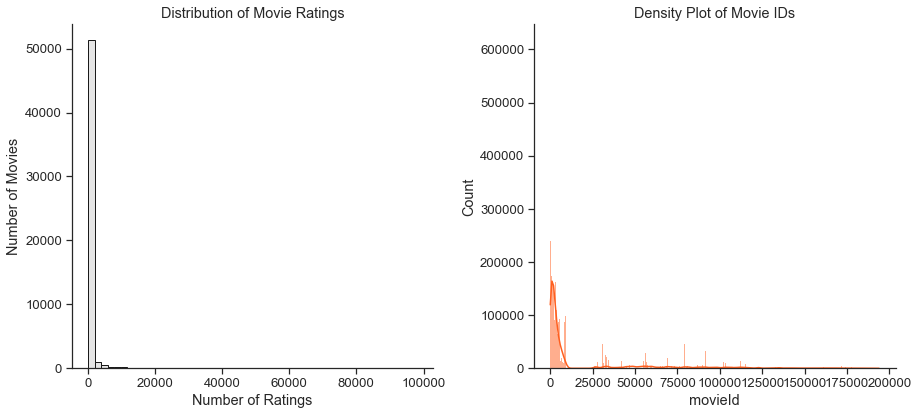

In [11]:
# Count movie rating counts
movie_rating_counts = df['movieId'].value_counts().reset_index()
movie_rating_counts.columns = ['movieId', 'rating_count']
movie_rating_counts = movie_rating_counts.sort_values(by='rating_count', ascending=False)

plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.hist(movie_rating_counts['rating_count'], bins=50, color="#E5E5E5", edgecolor='k')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Ratings')

# Density plot of movie IDs
plt.subplot(1,2,2)
sns.histplot(df['movieId'], kde=True, color='#FF5F1F')
plt.title('Density Plot of Movie IDs')
plt.tight_layout()
plt.show()

### Popular Movies 

**Most Rated Movies**   
On the left side, we show the "Most Rated Movies" plot. It displays the top 15 movies that have received the highest number of ratings. Each bar represents a movie, identified by its Movie ID on the x-axis. The height of each bar represents the number of ratings that the movie has received, indicated on the y-axis. 

**Average Ratings of Most Rated Movies**    
On the right side, we present the "Average Ratings of Most Rated Movies" plot. This plot focuses on the same top 15 most rated movies from the previous plot. However, instead of showing the count of ratings, it displays the average rating each of these movies has received. Again, Movie IDs are on the x-axis, and the y-axis represents the average rating. The movies with the highest number of ratings tend to cluster around an average rating of approximately 4 stars.

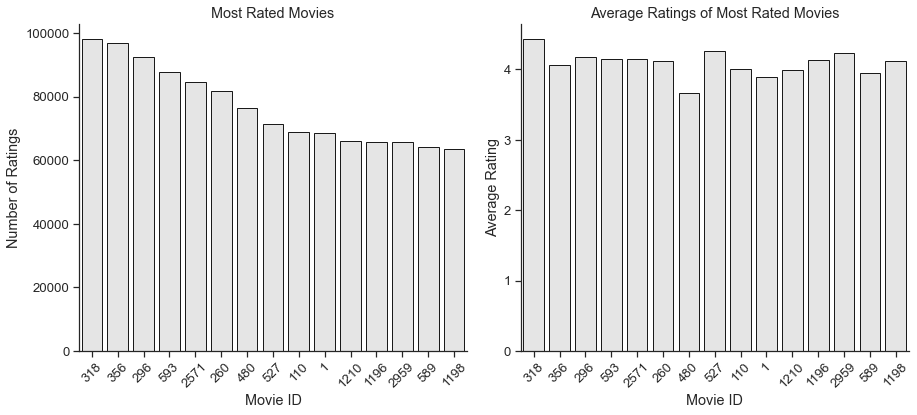

In [12]:
# Get the top 10 most rated movies
most_rated = df['movieId'].value_counts().head(15).reset_index()
most_rated.columns = ['movieId', 'count']
most_rated = most_rated.sort_values(by='count', ascending=False)

plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.title("Most Rated Movies")
sns.barplot(x='movieId', y='count', data=most_rated, color="#E5E5E5", edgecolor='k', order=most_rated['movieId'])
plt.xlabel('Movie ID')
plt.xticks(rotation=45) 
plt.ylabel('Number of Ratings')

# Get average ratings of most rated movies
avg_data = df.groupby('movieId', as_index=False)['rating'].mean()
temp = df.movieId.value_counts().reset_index()
temp.columns = ['movieId','count']
most_rated_rating = pd.merge(avg_data,temp,on='movieId')
most_rated_rating = most_rated_rating.sort_values('count',ascending=False)

plt.subplot(1, 2, 2)
plt.title("Average Ratings of Most Rated Movies")
sns.barplot(x='movieId', y='rating', data = most_rated_rating.head(15), color="#E5E5E5", edgecolor='k', order=most_rated['movieId'])
plt.xlabel('Movie ID')
plt.xticks(rotation=45) 
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

**Average Ratings: Highest and Lowest**   
The tables presented below display the top 15 movieIds with the highest and lowest ratings (5 and 0.5, respectively). Once more, these tables emphasize that the majority of movies receive relatively few ratings, indicated by `num_ratings`.

In [13]:
# Get the average rating and count of ratings for each movie
movie_ratings = df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
movie_ratings.columns = ['movieId', 'avg_rating', 'num_ratings']
highest_rated = movie_ratings.sort_values(by='avg_rating', ascending=False)
highest_rated.head(15)

,movieId,avg_rating,num_ratings
43805,169338,5.0,2
51585,187729,5.0,1
45018,172149,5.0,1
40484,160966,5.0,1
30667,134387,5.0,1
20064,98437,5.0,1
30684,134433,5.0,1
45019,172151,5.0,1
30751,134605,5.0,1
30765,134633,5.0,1


In [14]:
highest_rated.tail(15)

,movieId,avg_rating,num_ratings
50442,185055,0.5,1
48332,179867,0.5,1
36540,150122,0.5,1
28202,127048,0.5,1
30497,133941,0.5,2
50413,184991,0.5,1
48340,179885,0.5,1
34117,143397,0.5,1
38518,155481,0.5,1
36544,150148,0.5,1


### User Activity

**Distribution of User Activity**   
This histogram on the left illustrates the distribution of user activity within the MovieLens dataset. The horizontal axis represents the number of ratings given by users, while the vertical axis indicates the count of users who fall within each specific range or "bin" of rating activity. As observed from this plot, the majority of users tend to give relatively fewer ratings, with a peak in the lower range of ratings provided.

**Most Active Users**    
On the right side, there is a bar plot displaying the top 15 most active users. The horizontal axis lists the User IDs of these highly active users, while the vertical axis shows the number of ratings each user has given. This plot highlights a subset of users who have rated a significantly larger number of movies compared to the majority of users in the dataset.


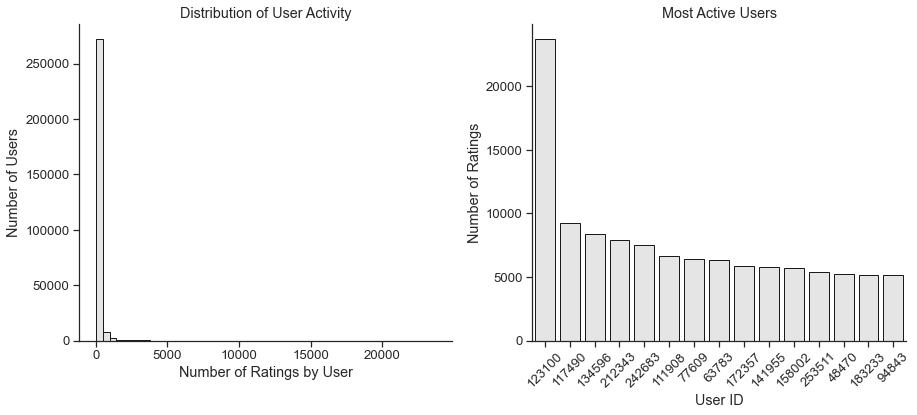

In [15]:
# Extract user rating counts
user_rating_counts = df['userId'].value_counts().reset_index()
user_rating_counts.columns = ['userId', 'rating_count']
user_rating_counts = user_rating_counts.sort_values(by='rating_count', ascending=False)

plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.hist(user_rating_counts['rating_count'], bins=50, color ='#E5E5E5', edgecolor='k')
plt.xlabel('Number of Ratings by User')
plt.ylabel('Number of Users')
plt.title('Distribution of User Activity')

# Get the top 10 most active users
most_active = df['userId'].value_counts().head(15).reset_index()
most_active.columns = ['userId', 'count']
most_active = most_active.sort_values(by='count', ascending=False)

plt.subplot(1, 2, 2)
plt.title("Most Active Users")
sns.barplot(x='userId', y='count', data=most_active, color="#E5E5E5", edgecolor='k', order=most_active['userId'])
plt.xlabel('User ID')
plt.xticks(rotation=45) 
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.show()

### Top-k Frequency Plot    

The plot below visualizes the relative frequency of the top-k most frequently rated movies in the MovieLens dataset. 
The horizontal axis represents the top-k movies, where k is a specified number (in this case, 5000). These are the movies with the highest number of ratings. The vertical axis represents the relative frequency, which is a normalized measure of how often each of the top-k movies appears in the dataset. It's essentially the proportion of ratings that belong to each of these top movies relative to the total number of ratings in the dataset. The orange line plot shows how the relative frequency changes as you move through the top-k movies. Each point on the line represents one of these movies, ordered by their frequency, starting with the most frequently rated.

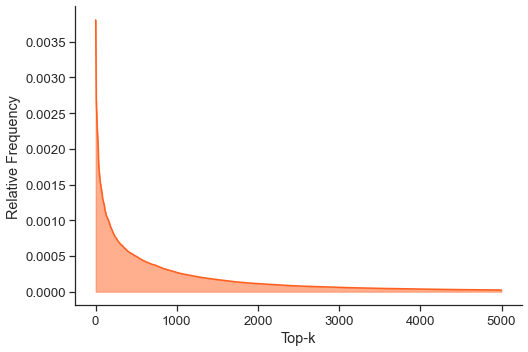

In [16]:
def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df['movieId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax, color='#FF5F1F')
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5, color='#FF5F1F')
    ax.set_ylabel("Relative Frequency")
    ax.set_xlabel("Top-k")

plot_frequency(df, k=5000)

### Distribution of Ratings Over Time 

The distribution of ratings exhibits a pronounced peak in the most recent year. Just prior to the year 2015, there is a minor decrease in the count of ratings. Apart from this dip, the number of ratings remains relatively stable over time.

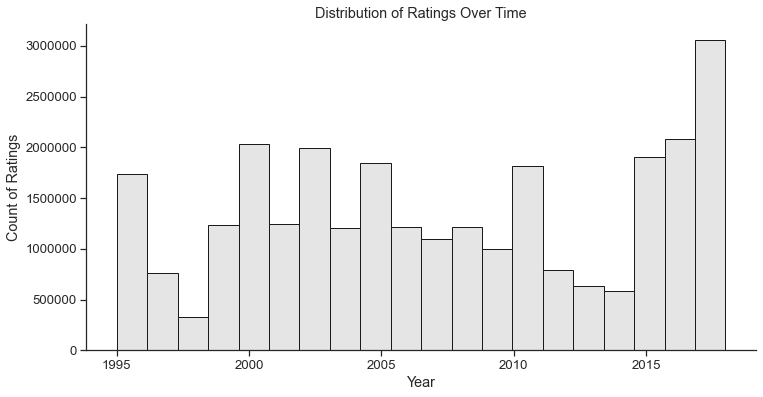

In [17]:
# Convert the 'timestamp' column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Create a histogram plot of the count of ratings across the timestamp column
plt.figure(figsize=(12, 6))
ax = df['timestamp'].dt.year.plot.hist(bins=20, edgecolor='k', color="#E5E5E5")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):}'))
plt.xlabel('Year')
plt.ylabel('Count of Ratings')
plt.title('Distribution of Ratings Over Time')
plt.show()

---

## Reducing the size of the dataset
### Pruning
Data pruning is a common practice in recommender systems research, involving the removal of instances from a dataset that would not be removed in real-world scenarios when used by recommender systems in production environments ([Beel & Brunel, 2017](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ceur-ws.org/Vol-2431/paper6.pdf)). Reasons for data pruning vary and include considerations such as user interests (e.g., data privacy) or business interests. It is distinct from data cleaning, like outlier removal, which is typically a prerequisite for effective training of recommender system and machine learning algorithms but doesn't directly affect algorithm performance ([Beel & Brunel, 2017](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ceur-ws.org/Vol-2431/paper6.pdf)).

In the context of the MovieLens dataset, data pruning often involves excluding ratings from users who rated fewer than  a certain number of movies ([Beel & Brunel, 2017](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ceur-ws.org/Vol-2431/paper6.pdf)). This is done because researchers need a sufficient number of ratings to evaluate algorithms, and it allows for a mix of training and test data. Additionally, early user ratings are influenced by the startup algorithm, making them less suitable for evaluation.

Individual researchers also engage in data pruning, as exemplified by [Caragea et al.](https://dl.acm.org/doi/10.1145/2467696.2467743) (2013), who pruned the CiteSeer corpus by removing research papers with fewer than ten or more than 100 citations, among other criteria. Similar practices were followed by [Pennock et al.](https://arxiv.org/abs/1301.3885) (2013) resulting in a significantly reduced dataset for their research ([Beel & Brunel, 2017](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ceur-ws.org/Vol-2431/paper6.pdf)).

### Select Recent Ratings
In data analysis, the relevance and recency of data are crucial for meaningful insights. Over time, movie preferences and audience tastes evolve. By concentrating on the most recent 10 years, we gain insight into the contemporary movie landscape and the choices of today's audiences. This allows us to provide recommendations that are better aligned with current trends. Besides, the entertainment industry has witnessed significant technological advancements, such as the rise of streaming platforms and the availability of high-definition content. To account for these changes, it's essential to consider data from the past 10 years, during which these developments have greatly impacted the movie-watching experience. Moreover, large datasets can pose computational challenges. By narrowing our focus to the most recent 10 years, we strike a balance between retaining valuable insights and managing the dataset's size, making it more computationally manageable without significantly sacrificing the quality of our analysis. Lastly, ratings of older movies might be less reliable due to fading memories, personal biases, or changes in reviewing standards. The more recent data ensures a higher degree of accuracy in capturing users' actual opinions.

In [18]:
df = df.sort_values(by='timestamp', ascending=False)

start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2018-12-31')
recent_ratings_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

Text(0.5, 1.0, 'Distribution of Ratings Over Time')

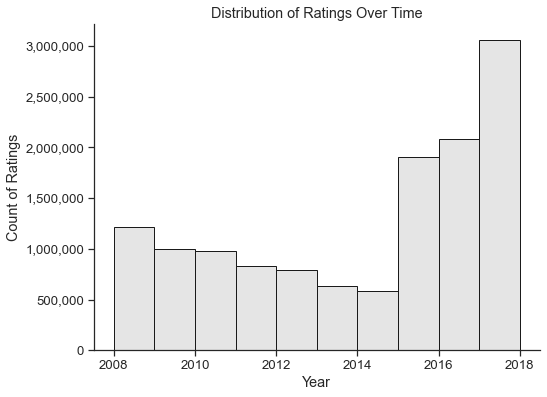

In [19]:
# Create a histogram plot of the count of ratings across the timestamp column
plt.figure(figsize=(8, 6))
ax = recent_ratings_df['timestamp'].dt.year.plot.hist(bins=10, edgecolor='k', color="#E5E5E5")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.xlabel('Year')
plt.ylabel('Count of Ratings')
plt.title('Distribution of Ratings Over Time')

The figure below displays the rating distribution for the past decade. Note that that this distribution resembles the one observed in the initial dataset, spanning the entire time frame. This similarity once more underscores the rationale for concentrating on the most recent 10 years. Doing so not only reduces computational demands by employing a smaller dataset but also maintains a comparable rating distribution.

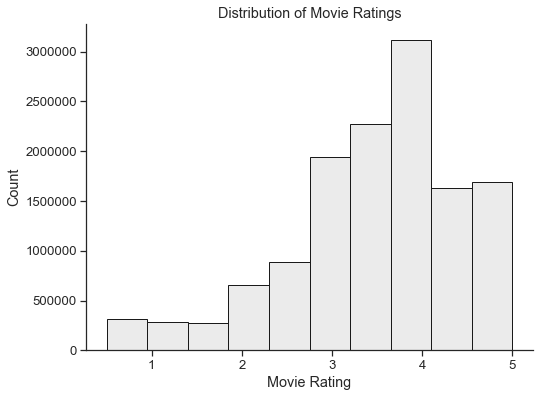

In [20]:
# Create distribution plot for movie ratings
plt.figure(figsize=(8, 6))
ax = sns.histplot(data=recent_ratings_df, x="rating", bins=10, edgecolor='k', color="#E5E5E5")
ax.set(title="Distribution of Movie Ratings", ylabel="Count", xlabel="Movie Rating")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):}'))

In [21]:
unique_users = len(recent_ratings_df['userId'].unique())
unique_movie = len(recent_ratings_df['movieId'].unique())

print('unique users: ' + str(unique_users)) 
print('unique movies: ' + str(unique_movie))

recent_ratings_df.shape

unique users: 131589
unique movies: 53846


(13074833, 4)

### Select Top-k Items 
The graph illustrates the impact of different k values on the size of a DataFrame. The k values represent the top k most frequently occurring movie IDs in the dataset. As k increases, meaning more movies are considered, the number of rows in the DataFrame also increases. This trend reflects the selection of movies that have more ratings, and thus, a higher k value results in more rows in the DataFrame. It's essential for understanding how the DataFrame size varies with different k values when dealing with large datasets and deciding how many movies to include in the analysis based on their popularity or frequency in the dataset.

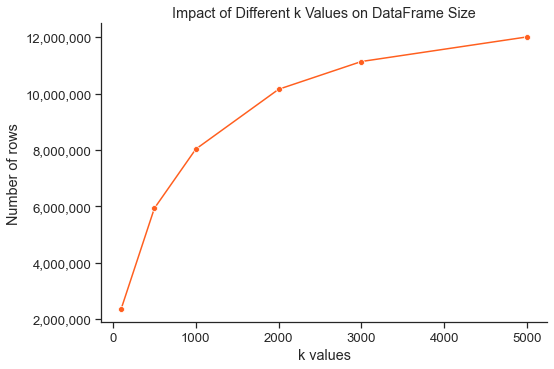

In [22]:
df = recent_ratings_df

def select(df, k, col):
    top_values = df[col].value_counts().nlargest(k)
    return df.loc[df[col].isin(top_values.index)]

def select_and_report(df, col, k_values):
    results = {}
    
    for k in k_values:
        selected_df = select(df, k, col)
        results[k] = len(selected_df)
    
    return results

# K values to try
k_values_to_try = [100, 500, 1000, 2000, 3000,5000]
results_dict = select_and_report(df, col='movieId', k_values=k_values_to_try)

# Extract k values and corresponding number of rows
k_values = list(results_dict.keys())
num_rows = list(results_dict.values())

# Create a line plot
plt.figure(figsize=(8,5.5))
ax = sns.lineplot(x=k_values, y=num_rows, marker='o', linestyle='-', color='#FF5F1F')
ax.set(title='Impact of Different k Values on DataFrame Size', ylabel='Number of rows', xlabel='k values')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.show()

In [23]:
print(results_dict)

{100: 2369697, 500: 5931111, 1000: 8031304, 2000: 10153620, 3000: 11139014, 5000: 12011589}


    For k = 100, the resulting DataFrame has 2,369,697 rows.
    For k = 500, the resulting DataFrame has 5,931,111 rows.
    For k = 1000, the resulting DataFrame has 8,031,304 rows.
    For k = 2000, the resulting DataFrame has 10,153,620 rows.
    For k = 3000, the resulting DataFrame has 11,139,014 rows.
    For k = 5000, the resulting DataFrame has 12,011,589 rows.
    

k = 1500 strikes a balance between coverage and granularity. It is large enough to provide a comprehensive view of the dataset, capturing a significant portion of items, while still being manageable for analysis. Processing is likely to be more efficient compared to larger values of k, especially the number of rows included provides a better coverage of the data, also with a larger k coverage is not improved. Anything more than k = 1500 might result in a dataset that is too large for practical analysis, both in terms of computation and interpretability. k = 1500 strikes a balance by offering a detailed subset without overwhelming the analysis.

Determining the ideal k value hinges on the unique goals and limitations of your analysis or recommendation system. the choice of k = 1500 as the best option is based on the consideration of a balance between coverage, granularity and computational efficiency. It is crucial to assess these aspects in the context of your project and domain expertise for a well-informed decision ([Karpus et al., 2017](https://annals-csis.org/Volume_11/drp/pdf/258.pdf)).

In [24]:
df = select(df, k=1500, col='movieId') 

### Select Users
The graph below demonstrates the relationship between memory usage and different user rating thresholds in a DataFrame. The user rating threshold represents the minimum number of ratings a user must have provided to be included in the analysis. As the threshold increases, signifying that users with fewer ratings are excluded, the memory usage of the DataFrame decreases. This reduction in memory usage is due to the removal of users with fewer ratings, resulting in a smaller subset of data. The graph provides insights into how adjusting the user rating threshold impacts the memory requirements for processing and storing the data, which is essential for optimizing computational resources and efficiently working with our large dataset.

As we have seen previously, the user-rating distribution in the MovieLens dataset used in this assignment exhibits a long-tail pattern. Many users have provided only a few ratings, while a smaller number of users have rated a substantial number of movies. Selecting users based on a specific rating threshold is a valuable strategy, as it allows us to focus our analysis on users with a more substantial contribution to the dataset. This approach is particularly useful in addressing computational challenges associated with the analysis of large datasets, as it significantly reduces memory and processing requirements by excluding users with minimal ratings. This approach is in line with the approach by Beel and Brunel ([2017](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ceur-ws.org/Vol-2431/paper6.pdf)).

Another reason to prune the dataset by selecting users who have rated less than a certain number of moves is to improve the quality of the recommendations. Users who have rated very few items might not provide enough data to make meaningful recommendations for them.

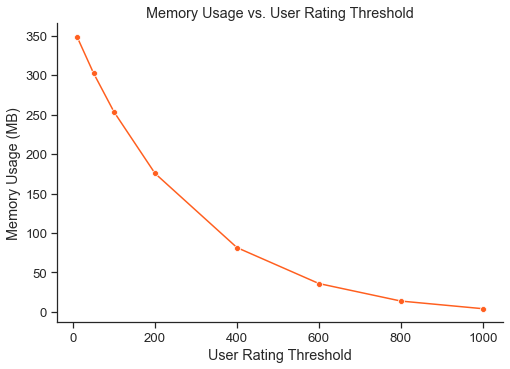

In [25]:
# User counts
user_rating_counts = df['userId'].value_counts()

# Define the range of thresholds
thresholds = [10, 50, 100, 200, 400, 600, 800, 1000]

# Initialize lists to store memory usage and corresponding thresholds
memory_usage = []
threshold_values = []

# Iterate through thresholds and filter the DataFrame
for threshold in thresholds:
    valid_user_ids = user_rating_counts[user_rating_counts > threshold].index
    filtered_df = df[df['userId'].isin(valid_user_ids)]
    
    # Append memory usage and threshold to lists
    memory_usage.append(filtered_df.memory_usage().sum() / (1024**2))  # Convert to MB
    threshold_values.append(threshold)

# Create a line plot
plt.figure(figsize=(8,5.5))
ax = sns.lineplot(x=threshold_values, y=memory_usage, marker='o', linestyle='-', color='#FF5F1F')
ax.set(title='Memory Usage vs. User Rating Threshold', ylabel='Memory Usage (MB)', xlabel='User Rating Threshold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.show()

In selecting an appropriate threshold for user ratings in the MovieLens dataset, our primary concern was the computational expensiveness associated with analyzing a vast amount of data. After evaluating different threshold values, it became evident that setting the threshold at 400 was an optimal choice. At this threshold, we strike a balance between retaining a substantial portion of the dataset while significantly reducing the computational resources required for analysis. With a threshold of 400, we retain the most active users who have rated a considerable number of movies, ensuring that our analysis remains meaningful and that we capture valuable user-item interactions. Simultaneously, this choice allows us to alleviate the computational burden, making the analysis more feasible without compromising the integrity of the dataset. The memory usage dropped notably from 175.49 MB with a threshold of 200 to 81.51 MB with a threshold of 400, demonstrating the substantial impact of this threshold in optimizing computational efficiency while retaining essential data for analysis.

In [26]:
# Find the user IDs with more than 400 ratings
valid_user_ids = user_rating_counts[user_rating_counts > 400].index
filtered_df = df[df['userId'].isin(valid_user_ids)]

In [27]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136785 entries, 8060104 to 19172453
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 81.5 MB


In [28]:
unique_users = len(filtered_df['userId'].unique())
unique_movie = len(filtered_df['movieId'].unique())

print('unique users: ' + str(unique_users)) 
print('unique movies: ' + str(unique_movie))

filtered_df.shape

unique users: 3714
unique movies: 1500


(2136785, 4)

---

## Part II: Recommender System Models

In order to apply the strategy of optimizing hyperparameters on a smaller dataset and subsequently using those configurations to build the final model on a larger dataset, the following steps were followed:

1. **Dataset Splitting**: The entire dataset was divided into two parts: a smaller dataset (10% of the data) and a larger dataset (the remaining data). It was ensured that the smaller dataset maintained the same distribution as the larger one.

2. **Model Selection**: In this step, the neighborhood-based and matrix factorization-based models available through the scikit-surprise package were considered. The choice of model was informed by a evaluation of each model's suitability to our dataset, as well as a review of their documented performance in existing literature.

3. **Hyperparameter Tuning on Smaller Dataset**: After choosing the models, grid search was used to fine-tune the chosen algorithm. This was done using the smaller dataset. 

4. **Application of Best Hyperparameters to Larger Dataset**: After identifying the best hyperparameters for the selected algorithms on the smaller dataset, these hyperparameters were applied to train the final models on the larger dataset. This ensures that the final model is built on a dataset with a decent size while benefiting from the optimal configuration based on the smaller dataset.

### Splitting the Data
When splitting the larger dataset into smaller and larger parts, random sampling was used. This involved the random selection of a subset of data points to constitute the smaller dataset, ensuring that each data point had an equal probability of being chosen. This approach was chosen to preserve the statistical characteristics of the original dataset. To enhance the assurance that the smaller dataset maintains a consistent distribution with the larger dataset, the distribution of the ratings of the two datasets was visually examined through histograms. These histograms show that the distributions of the smaller and larger dataset are almost identical.

In [30]:
filtered_df.drop(columns=['timestamp'], inplace=True)

# Randomly shuffle the data
shuffled_data = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data
smaller_data = shuffled_data[:int(len(shuffled_data) * 0.1)]
larger_data = shuffled_data[int(len(shuffled_data) * 0.1):]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


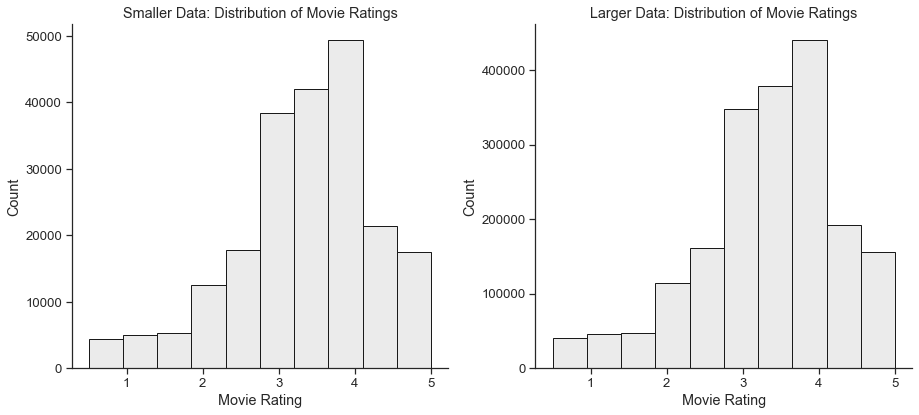

In [31]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Create distribution plot for movie ratings - smaller_data
sns.histplot(data=smaller_data, x="rating", bins=10, edgecolor='k', color="#E5E5E5", ax=axes[0])
axes[0].set(title="Smaller Data: Distribution of Movie Ratings", ylabel="Count", xlabel="Movie Rating")
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):}'))

# Create distribution plot for movie ratings - larger_data
sns.histplot(data=larger_data, x="rating", bins=10, edgecolor='k', color="#E5E5E5", ax=axes[1])
axes[1].set(title="Larger Data: Distribution of Movie Ratings", ylabel="Count", xlabel="Movie Rating")
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):}'))

# Display the subplots
plt.tight_layout()
plt.show()

**Correct Format of Data (According to Surprise Principles)**    
Until now, we've loaded our data as a Pandas dataframe from a CSV file. However, as indicated in the tutorial introduction notebook on [Canvas](https://tilburguniversity.instructure.com/courses/14982/files/2575499?module_item_id=586691), when working with recommender system algorithms, it's essential to create a proper Dataset to feed the data into these algorithms. Hence, we will make use of the `load_from_df` function. This process involves two main steps.

Firstly, we create a `Reader` object, which is responsible for parsing a file containing ratings. If the data is loaded directly from a file, the input file is expected to have one rating per line, following this structure: `user` ; `movieId` ; `rating`. In either case, we need to configure the `rating_scale` parameter to indicate the rating scale used in our dataset: 1-5. Secondly, we specify the column names and create the dataset object.

In [32]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(0.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
smaller_dataset = Dataset.load_from_df(smaller_data[['userId', 'movieId', 'rating']], reader)

In [33]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(0.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
larger_dataset = Dataset.load_from_df(larger_data[['userId', 'movieId', 'rating']], reader)

--- 

### Baseline Model: Normal Predictor
The assigned baseline model for this assignment is called `NormalPredictor`. This algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. The prediction $\hat{r}_{ui}$ is generated from a normal distribution $\mathcal{N}(\hat{\mu}, \hat{\sigma}^2)$ where 
$\hat{\mu}$ and $\hat{\sigma}$ are estimated from the training data using Maximum Likelihood Estimation ([Surprise](https://surprise.readthedocs.io/en/stable/basic_algorithms.html)):

\\begin{split}\hat{\mu} &= \frac{1}{|R_{train}|} \sum_{r_{ui} \in R_{train}} r_{ui}\\\\ \hat{\sigma} &= \sqrt{\sum_{r_{ui} \in R_{train}} \frac{(r_{ui} - \hat{\mu})^2}{|R_{train}|}}\end{split}

For this model, we will only use the larger dataset, because the baseline model involves no hyperparameter tuning.

In [34]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

start_time = time.time()
results_normalpredictor = cross_validate(NormalPredictor(), larger_dataset, cv=cv, return_train_measures=True)
end_time = time.time()
elapsed_time_normal_predictor = end_time - start_time

### Evaluation Metrics
Root Mean Squared Error (RMSE) for evaluating recommendation systems is commonly applied in most context due to its sensitivity to both overestimations and underestimations, simplicity in computation, widespread adoption, and meaningful representation of overall prediction accuracy ([Zeshan et al, 2020](https://www.mdpi.com/2076-3417/10/21/7748)).

Mean Absolute Error (MAE) is an another evaluation metric commonly recommended for recommender systems because it provides a straightforward and interpretable measure of the average absolute errors in the predicted ratings. Unlike RMSE, MAE is less sensitive to extreme outliers, making it robust in the presence of large errors ([Shinde et al, 2015](https://www.semanticscholar.org/paper/Survey-on-Evaluation-of-Recommender-Systems-Shinde-Potey/a38548d76d4c05809daa22472599055bbdd8fec3)). 

These two evaluation metrics are chosen as they best facilitiate comparisons between different algorithms, assess different types of errors, provide straightforward interpretability, and are sensetive to prediction errors. 

In [35]:
rmse_NormalPredictor_array = np.array(results_normalpredictor['test_rmse'])
mae_NormalPredictor_array = np.array(results_normalpredictor['test_mae'])
print('Average RMSE NormalPredictor:', round(np.mean(rmse_NormalPredictor_array), 4))
print('Average MAE NormalPredictor:', round(np.mean(mae_NormalPredictor_array), 4))
print(f'Elapsed time for NormalPredictor: {(elapsed_time_normal_predictor/60):.2f} minutes')

Average RMSE NormalPredictor: 1.3979
Average MAE NormalPredictor: 1.1127
Elapsed time for NormalPredictor: 3.22 minutes


---

### Model 1: Neighborhood-Based Method

The following neighborhood-based algortihms are considered in this assignment: (1) knns.KNNBasic, (2) knns.KNNWithMeans, (3) knns.KNNWithZscore, and (4) knns.KNNBaseline. These algorithms are available under the [Surprise](https://surprise.readthedocs.io/en/stable/basic_algorithms.html) package. 

---

**knns.KNNBasic**    
This algorithm is a basic collaborative filtering algorithm. The prediction $\hat{r}_{ui}$ is set as:

$\hat{r}_{ui} = \frac{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)}$

The algorithm considers the following parameters ([Surprise](https://surprise.readthedocs.io/en/stable/knn_inspired.html)):

* k (_int_) - The (max) number of neighbors to take into account for aggregation. 
* min_k (_int_) - The minimum number of neighbors to take into account for aggregation.
* sim_options (_dict_) - A dictionary of options for the similarity measure.
* verbose (_bool_) - Whether to print trace messages of bias estimation, similarity, etc. 

---
     
**knns.KNNWithMeans**    
This is a basic collaborative filtering algorithm, taking into account the mean ratings of each user. The prediction $\hat{r}_{ui}$ is set as:

$\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}$

The algorithm considers the following parameters ([Surprise](https://surprise.readthedocs.io/en/stable/knn_inspired.html)):

* k (_int_) - The (max) number of neighbors to take into account for aggregation. 
* min_k (_int_) - The minimum number of neighbors to take into account for aggregation.
* sim_options (_dict_) - A dictionary of options for the similarity measure.
* verbose (_bool_) - Whether to print trace messages of bias estimation, similarity, etc. 

---

**knns.KNNWithZscore**  
This is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user. The prediction $\hat{r}_{ui}$ is set as:

$\hat{r}_{ui} = \mu_u + \sigma_u \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v} {\sum\limits_{v
\in N^k_i(u)} \text{sim}(u, v)}$

The algorithm considers the following parameters ([Surprise](https://surprise.readthedocs.io/en/stable/knn_inspired.html)):

* k (_int_) - The (max) number of neighbors to take into account for aggregation. 
* min_k (_int_) - The minimum number of neighbors to take into account for aggregation.
* sim_options (_dict_) - A dictionary of options for the similarity measure.
* verbose (_bool_) - Whether to print trace messages of bias estimation, similarity, etc. 

---

**knns.KNNBaseline**    
This is a basic collaborative filtering algorithm, taking into account a baseline rating. The prediction $\hat{r}_{ui}$ is set as:

$\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}$

The algorithm considers the following parameters ([Surprise](https://surprise.readthedocs.io/en/stable/knn_inspired.html)):

* k (_int_) - The (max) number of neighbors to take into account for aggregation. 
* min_k (_int_) - The minimum number of neighbors to take into account for aggregation.
* sim_options (_dict_) - A dictionary of options for the similarity measure.
* verbose (_bool_) - Whether to print trace messages of bias estimation, similarity, etc. 

---

**2. Model Selection**    
Among the collaborative filtering models considered, we chose for KNNBasic. This algorithm forms the foundation of collaborative filtering and provides a simple yet effective approach to recommendation systems. We decided against more complex variants of KNN, such as KNNWithMeans, KNNWithZscore, and KNNBaseline, as our data showed no strong indications of clear biases or trends that could be effectively captured by baseline predictions. By opting for a more straightforward collaborative filtering method, we aim to achieve a good balance between model complexity and predictive accuracy. It's important to note that a more complex model is not necessarily superior, and KNNBasic aligns well with the nature of our dataset. In essence, KNNBasic offers an excellent starting point for building an efficient recommendation system tailored to our specific requirements ([Li et al., 2020](https://www.semanticscholar.org/paper/The-Research-for-Recommendation-System-Based-on-KNN-Li-Wan/e22fb46806831d6af6e9dcd21a5ecfa05f7b30a9)).

**3. Hyperparameter Tuning on Smaller Dataset**    
We chose to perform hyperparameter tuning on the KNNBasic collaborative filtering algorithm using a range of hyperparameter values to ensure that our model is optimized for accuracy. The hyperparameters we focused on include `k`, which determines the number of neighbors to consider for aggregation, and `min_k`, which sets the minimum number of neighbors required for aggregation. By exploring a variety of `k` values (ranging from 20 to 50) and `min_k` values (ranging from 1 to 10), we aim to identify the combination that results in the lowest RMSE and MAE. Additionally, we set `user_based` to 'False' to indicate item-based collaborative filtering. The `verbose` parameter is set to 'False' to avoid excessive output during the tuning process. This comprehensive hyperparameter tuning approach ensures that our KNNBasic model is fine-tuned to provide the best possible recommendations.

In [36]:
# Perform hyperparameter tuning on the smaller dataset
param_grid = {'k': [20, 30, 40, 50], 'min_k': [1, 3, 5, 7, 10], 'user_based': [False], 'verbose': [False]}
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search.fit(smaller_dataset)

# Get the best hyperparameters for each algorithm
best_params = grid_search.best_params

In [37]:
print(best_params)

{'rmse': {'k': 40, 'min_k': 1, 'user_based': False, 'verbose': False}, 'mae': {'k': 40, 'min_k': 1, 'user_based': False, 'verbose': False}}


**4. Application of Best Hyperparameters to Larger Dataset**

In [38]:
# Create the KNNBasic model with the best hyperparameters
final_model_knn = KNNBasic(k=40, min_k=1, user_based=False, verbose=False)

In [39]:
# Perform cross-validation to evaluate the final knn model on the larger dataset
cv = KFold(n_splits=5, random_state=42, shuffle=True)

start_time = time.time()
results_knn = cross_validate(final_model_knn, larger_dataset, cv=cv, return_train_measures=True)
end_time = time.time()
elapsed_time_knn = end_time - start_time

In [40]:
# Print the average RMSE and MAE for the final model
rmse_array_knn = np.array(results_knn['test_rmse'])
mae_array_knn = np.array(results_knn['test_mae'])
print(f'Average RMSE for KNNBasic:', round(np.mean(rmse_array_knn), 4))
print(f'Average MAE for KNNBasic:', round(np.mean(mae_array_knn), 4))
print(f'Elapsed time for KNNBasic: {(elapsed_time_knn/60/60):.2f} hours')

Average RMSE for KNNBasic: 0.7948
Average MAE for KNNBasic: 0.594
Elapsed time for KNNBasic: 3.37 hours


---

### Model 2: Matrix Factorization-Based Method

The following matrix factorization-based algortihms are considered in this assignment: (1) SVD, (2) SVD++, and (3) NMF. These algorithms are available under the [Surprise](https://surprise.readthedocs.io/en/stable/basic_algorithms.html) package. 

---

**SVD**    
SVD (Singular Value Decomposition) is a matrix factorization technique that decomposes the user-item rating matrix into lower-dimensional matrices to capture latent factors. The prediction $\hat{r}_{ui}$ is set as:

$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ as assumed to be zero. The same applies for the item $i$ ith $b_i$ and $q_i$. To estimate all the unknown, we minimize the following regularized squared error:

$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)$

The minimization is performed by a stochastic gradient descent:

$\begin{split}b_u &\leftarrow b_u &+ \gamma (e_{ui} - \lambda b_u)\\
b_i &\leftarrow b_i &+ \gamma (e_{ui} - \lambda b_i)\\
p_u &\leftarrow p_u &+ \gamma (e_{ui} \cdot q_i - \lambda p_u)\\
q_i &\leftarrow q_i &+ \gamma (e_{ui} \cdot p_u - \lambda q_i)\end{split}$

where $e_{ui} = r_{ui} - \hat{r}_{ui}$. 

The algorithm considers the following parameters ([Surprise](https://surprise.readthedocs.io/en/stable/knn_inspired.html)):

* n_factors – The number of factors.
* n_epochs – The number of iteration of the SGD procedure. 
* biased (_bool_) – Whether to use baselines (or biases).
* init_mean – The mean of the normal distribution for factor vectors initialization.
* init_std_dev – The standard deviation of the normal distribution for factor vectors initialization. 
* lr_all – The learning rate for all parameters. 
* reg_all – The regularization term for all parameters. 
* lr_bu – The learning rate for $b_u$ (i.e., the user biases).
* lr_bi – The learning rate for $b_i$ (i.e., the item biases).
* lr_pu – The learning rate for $p_u$ (i.e., the user factors).
* lr_qi – The learning rate for $q_i$ (i.e., the item factors).
* reg_bu – The regularization term for $b_u$.
* reg_bi – The regularization term for $b_i$.
* reg_pu – The regularization term for $p_u$.
* reg_qi – The regularization term for $q_i$.
* random_state (int, RandomState instance from numpy, or None) – Determines the RNG that will be used for initialization. If int, random_state will be used as a seed for a new RNG. This is useful to get the same initialization over multiple calls to fit(). If RandomState instance, this same instance is used as RNG. If None, the current RNG from numpy is used. 
* verbose – If True, prints the current epoch.

---
     
**SVD++**   
SVD++ is an extension of SVD that incorporates implicit user feedback in addition to explicit ratings for improved collaborative filtering. The prediction $\hat{r}_{ui}$ is set as:

$\hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$

where the $y_j$ term are a new set of item factors that capture implict ratings. Here, an implicit rating describes the fact that a user $u$ rated an item $j$, regardless of the rating value. If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ as assumed to be zero. The same applies for the item $i$ ith $b_i$ and $q_i$.

Just as for SVD, the parameters are learning using a SGD on the regularized squared error objective.

The algorithm considers the following parameters ([Surprise](https://surprise.readthedocs.io/en/stable/knn_inspired.html)):

* n_factors – The number of factors.
* n_epochs – The number of iteration of the SGD procedure. 
* cache_ratings - Whether or not to chace ratings during fit. The should speed-up the training, and has a higher memory footprint.
* init_mean – The mean of the normal distribution for factor vectors initialization.
* init_std_dev – The standard deviation of the normal distribution for factor vectors initialization. 
* lr_all – The learning rate for all parameters. 
* reg_all – The regularization term for all parameters. 
* lr_bu – The learning rate for $b_u$ (i.e., the user biases).
* lr_bi – The learning rate for $b_i$ (i.e., the item biases).
* lr_pu – The learning rate for $p_u$ (i.e., the user factors).
* lr_qi – The learning rate for $q_i$ (i.e., the item factors).
* reg_bu – The regularization term for $b_u$.
* reg_bi – The regularization term for $b_i$.
* reg_pu – The regularization term for $p_u$.
* reg_qi – The regularization term for $q_i$.
* random_state (int, RandomState instance from numpy, or None) – Determines the RNG that will be used for initialization. If int, random_state will be used as a seed for a new RNG. This is useful to get the same initialization over multiple calls to fit(). If RandomState instance, this same instance is used as RNG. If None, the current RNG from numpy is used. 
* verbose – If True, prints the current epoch.

---

**NMF**  
NMF (Non-negative Matrix Factorization) is a collaborative filtering algorithm based on matrix factorization, where the user-item matrix is approximated as the product of two non-negative matrices to capture underlying patterns. The prediction $\hat{r}_{ui}$ is set as:

$\hat{r}_{ui} = q_i^Tp_u$

where user and item factors are kept positive. The optimitzation procedure is a (regularized) stochastic gradient descent with a specific choise of step size that ensures non-negativity of factors, provided that their initial values are also positive. At each step of the SGD procedure, the factors $f$ or user $u$ and item $i$ are updated as follows:

$\begin{split}p_{uf} &\leftarrow p_{uf} &\cdot \frac{\sum_{i \in I_u} q_{if}
\cdot r_{ui}}{\sum_{i \in I_u} q_{if} \cdot \hat{r_{ui}} +
\lambda_u |I_u| p_{uf}}\\
q_{if} &\leftarrow q_{if} &\cdot \frac{\sum_{u \in U_i} p_{uf}
\cdot r_{ui}}{\sum_{u \in U_i} p_{uf} \cdot \hat{r_{ui}} +
\lambda_i |U_i| q_{if}}\\\end{split}$

where $\lambda_u$ and $\lambda_i$ are regularization parameters. 

The algorithm considers the following parameters ([Surprise](https://surprise.readthedocs.io/en/stable/knn_inspired.html)):

* n_factors – The number of factors.
* n_epochs – The number of iteration of the SGD procedure. 
* biased (_bool_) – Whether to use baselines (or biases).
* reg_pu – The regularization term for $\lambda_u$.
* reg_qi – The regularization term for $\lambda_i$.
* reg_bu – The regularization term for $b_u$.
* reg_bi – The regularization term for $b_i$.
* lr_bu – The learning rate for $b_u$. 
* lr_bi – The learning rate for $b_i$.
* init_low – Lower bound for random initialization of factors.
* init_high - Higher bound for random initialization of factors. 
* random_state (int, RandomState instance from numpy, or None) – Determines the RNG that will be used for initialization. If int, random_state will be used as a seed for a new RNG. This is useful to get the same initialization over multiple calls to fit(). If RandomState instance, this same instance is used as RNG. If None, the current RNG from numpy is used. 
* verbose – If True, prints the current epoch.

---

**2. Model Selection**  
In this assignment, we considered three matrix factorization-based algorithms to build a recommender system: SVD (Singular Value Decomposition), SVD++, and NMF (Non-negative Matrix Factorization). We chose to implement the SVD++ algorithm for several reasons.

SVD is a fundamental matrix factorization technique that captures latent factors in the user-item rating matrix to make predictions. SVD++ builds upon SVD by incorporating implicit user feedback alongside explicit ratings, enhancing its collaborative filtering capabilities. The inclusion of implicit ratings is especially valuable because it captures user behavior beyond numerical ratings, improving recommendation quality. The regularization and learning rate parameters in the Surprise library allow us to fine-tune the model's performance.

Among the algorithms considered, SVD++ demonstrated a strong balance between accuracy and computational efficiency, making it the optimal choice for our recommender system. It provides reliable recommendations while maintaining a reasonable runtime, crucial for real-time applications. Additionally, SVD++'s interpretability and adjustable parameters offer flexibility in fine-tuning its performance.

Lastly, related studies in the field have clearly pointed to a higher prediction error associated with the Non-negative Matrix Factorization (NMF) algorithm compared to SVD++ (e.g., [Huda et al., 2023](https://pubs.aip.org/aip/acp/article-abstract/2508/1/020020/2878879/Comparison-of-matrix-factorization-algorithms?redirectedFrom=fulltext); [Yi et al., 2023](https://dl.acm.org/doi/abs/10.1016/j.ins.2023.01.015); [Beel & Brunel, 2017](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ceur-ws.org/Vol-2431/paper6.pdf)).

**3. Hyperparameter Tuning on Smaller Dataset**   
We fine-tuned the hyperparameters of our SVD++ collaborative filtering model, aiming to optimize its performance for accuracy. To achieve this, we  selected a set of hyperparameters to focus on, ensuring that each contributes significantly to the model's overall performance. The hyperparameters we explored include the number of epochs (`n_epochs`), which determines the number of iterations the model undergoes, the learning rate for all parameters (`lr_all`), and the regularization term for all parameters (`reg_all`). These parameters were chosen for their profound influence on the model's predictive capabilities. We explored a range of values for each hyperparameter, specifically testing `n_epochs` in the range of 10 to 30, `lr_all` spanning from 0.002 to 0.01, and `reg_all` varying between 0.02 to 0.06. Our choice to include these specific values in our search was driven by our aim to include a wide array of possibilities, spanning from subtle fine-tuning to more substantial alterations. This approach guarantees that we not only pinpoint the optimal configuration for our SVD++ model but also consider potential performance variations in different scenarios. To streamline the tuning process and avoid excessive output, we set the verbose parameter to 'False.' 

In [41]:
# Define the parameter grid for hyperparameter tuning
param_grid_SVDpp = {
    'n_epochs': [10, 20, 30],        
    'lr_all': [0.002, 0.005, 0.01],  
    'reg_all': [0.02, 0.04, 0.06],   
    'verbose': [False]              
}

grid_search_svdpp = GridSearchCV(SVDpp, param_grid_SVDpp, measures=['rmse', 'mae'], cv=5)
grid_search_svdpp.fit(smaller_dataset)

# Get the best hyperparameters for SVD++
best_params_svdpp = grid_search_svdpp.best_params

In [42]:
print(best_params_svdpp)

{'rmse': {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.06, 'verbose': False}, 'mae': {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.06, 'verbose': False}}


**4. Application of Best Hyperparameters to Larger Dataset**   
We opted to focus on achieving the optimal parameters for RMSE rather than MAE. RMSE places a higher emphasis on the accurate prediction of user ratings and is more sensitive to larger errors, making it a suitable choice for our use case. The parameter configuration we selected for RMSE optimization – `n_epochs`: 20, `lr_all`: 0.01, `reg_all`: 0.06, and `verbose`: False – is designed to yield the lowest RMSE values, aligning with our primary objective of delivering highly accurate recommendations to users.

In [43]:
# Create the SVD++ model with the best hyperparameters
final_svdpp_model = SVDpp(n_epochs=20, lr_all=0.01, reg_all=0.06, verbose=False)

In [44]:
# Perform cross-validation to evaluate the final SVD model on the larger dataset
cv = KFold(n_splits=5, random_state=42, shuffle=True)

start_time = time.time()
results_svd = cross_validate(final_svdpp_model, larger_dataset, cv=cv, return_train_measures=True)
end_time = time.time()
elapsed_time_svd = end_time - start_time

In [47]:
# Print the average RMSE and MAE for the final model
rmse_array_svd = np.array(results_svd['test_rmse'])
mae_array_svd = np.array(results_svd['test_mae'])
print(f'Average RMSE for SVD++:', round(np.mean(rmse_array_svd), 4))
print(f'Average MAE for SVD++:', round(np.mean(mae_array_svd), 4))
print(f'Elapsed time for SVD++: {(elapsed_time_svd/60/60):.2f} hours')

Average RMSE for KNNBasic: 0.7408
Average MAE for KNNBasic: 0.5591
Elapsed time for KNNBasic: 2.92 hours


---

### Model Evaluation: Normal Predictor, KNNBasic, and SVD++
As discussed previously, we compared three different models: NormalPredictor, KNNBasic, and SVD++. Each model was evaluated based on RMSE and MAE, which provide insights into the accuracy of their predictions. The RMSE quantifies the magnitude of prediction errors, with lower values indicating better accuracy. Similarly, the MAE measures the average absolute difference between predicted and actual ratings. It is evident from the evaluation table below that the SVD++ model outperforms both NormalPredictor and KNNBasic in terms of lower RMSE and MAE. Specifically, the RMSE for SVD++ is 0.7408, while the RMSE for KNNBasic is 0.7948. The MAE for SVD++ is 0.5591, and the MAE for KNNBasic is 0.5940. These numbers indicate superior prediction accuracy for SVD++. Moreover, SVD++ also exhibits faster execution times, with a running time of 2.92 hours, compared to KNNBasic's running time of 3.37 hours. In conclusion, the results lead us to choose the SVD++ model as the optimal recommendation algorithm for our specific use case.

In [61]:
model_results = {
    'Model': ['NormalPredictor', 'KNNBasic', 'SVD++'],
    'Average RMSE': [
        round(np.mean(rmse_NormalPredictor_array), 4),
        round(np.mean(rmse_array_knn), 4),
        round(np.mean(rmse_array_svd), 4)
    ],
    'Average MAE': [
        round(np.mean(mae_NormalPredictor_array), 4),
        round(np.mean(mae_array_knn), 4),
        round(np.mean(mae_array_svd), 4)
    ],
    'Running Time': [
        f"{round(elapsed_time_normal_predictor/60/60, 2)} hours",
        f"{round(elapsed_time_knn/60/60, 2)} hours",
        f"{round(elapsed_time_svd/60/60, 2)} hours"
    ]
}

# Display the results table
results_table = pd.DataFrame(model_results)
results_table

,Model,Average RMSE,Average MAE,Running Time
0,NormalPredictor,1.3979,1.1127,0.05 hours
1,KNNBasic,0.7948,0.5940,3.37 hours
2,SVD++,0.7408,0.5591,2.92 hours


**Suggested Improvements**    
To enhance the performance of our recommendation system, there are several areas for improvement. First, increasing the volume of data by incorporating more users and ratings would contribute to more accurate and robust recommendations. Besides, the addition of richer user data, such as user demographics, preferences, and historical behaviors, could further refine the system's ability to provide personalized suggestions. Additionally, exploring advanced recommendation techniques, including hybrid models that combine collaborative and content-based approaches, could lead to even more precise recommendations. Fine-tuning the hyperparameters of our chosen algorithms and incorporating innovative methods for cold-start problem mitigation are also areas for potential refinement. Lastly, considering the dynamic nature of user preferences, implementing real-time recommendation updates could ensure that the system adapts to evolving user behaviors, providing a more engaging user experience.

---

## References

- Beel, J., & Brunel, V. (2019). Data pruning in Recommender Systems Research: Best-Practice or Malpractice? _Conference on Recommender Systems, 26–30_. http://ceur-ws.org/Vol-2431/paper6.pdf

- Huda, S. N., Rani, S., & Fudholi, D. H. (2023). Comparison of matrix factorization algorithms’ performance in tourist attraction recommendations. _AIP Conference Proceedings, 2508_. https://pubs.aip.org/aip/acp/article-abstract/2508/1/020020/2878879/Comparison-of-matrix-factorization-algorithms?redirectedFrom=fulltext

- Karpus, A., Noia, T. D., & Goczyła, K. (2017). Top k recommendations using contextual conditional preferences model. _2017 Federated Conference on Computer Science and Information Systems (FedCSIS), 19-28_. https://annals-csis.org/Volume_11/drp/pdf/258.pdf

- Li, B., Wan, S., Xia, H., & Qian, F. (2020). The Research for Recommendation System Based on Improved KNN Algorithm. _IEEE International Conference on Advances in Electrical Engineering and Computer Applications (AEECA)_. https://www.semanticscholar.org/paper/The-Research-for-Recommendation-System-Based-on-KNN-Li-Wan/e22fb46806831d6af6e9dcd21a5ecfa05f7b30a9

- Shinde, S., & Potey, M. A. (2015). Survey on Evaluation of Recommender Systems. https://www.semanticscholar.org/paper/Survey-on-Evaluation-of-Recommender-Systems-Shinde-Potey/a38548d76d4c05809daa22472599055bbdd8fec3

- Xu, Y., Wang, M., & Luo, F. (2023). The movement strategy of three-way decisions based on clustering. _Information Sciences, 625_, 175-191. https://dl.acm.org/doi/abs/10.1016/j.ins.2023.01.015

- Zeshan, F., & Ebrahimian, M. (2020). Recommendation Systems: Algorithms, Challenges, Metrics, and Business Opportunities. _Applied Sciences_. https://www.mdpi.com/2076-3417/10/21/7748

---